In [1]:
%load_ext autoreload
%autoreload 2

In [72]:
import os.path
import keras
import numpy as np
from matplotlib import pyplot as plt
from fnn_helper import PlotLosses
from MNIST_helper import plot_numbers, visualize_input
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from fnn_helper import PlotLosses
from keras_contrib.callbacks import CyclicLR
from matplotlib import pyplot as plt
import draw_nn
if not os.path.exists('mlp_helper.py'):
    !wget https://github.com/lab-ml-itba/MLP-2019/raw/master/mlp_helper.py
    !wget https://github.com/lab-ml-itba/MLP-2019/raw/master/fnn_helper.py
    !wget https://github.com/lab-ml-itba/MLP-2019/raw/master/MNIST_helper.py
    !wget https://github.com/lab-ml-itba/MLP-2019/raw/master/draw_nn.py

# Split data

In [3]:
(x, y), (x_test, y_test) = mnist.load_data()

# 20% del dataset para validación
validation = 0.20
N_validation_split = int(x.shape[0]*(1-validation))
# Training Set
x_train = x[:N_validation_split]
y_train = y[:N_validation_split]

# Cross Validation Set
x_val = x[N_validation_split:]
y_val = y[N_validation_split:]
print('Training set data:', x_train.shape)
print('Training labels:', y_train.shape)
print()
print('CV set data:', x_val.shape)
print('CV labels:', y_val.shape)
print()
print('Testing set data:',x_test.shape)
print('Testing labels:', y_test.shape)

Training set data: (48000, 28, 28)
Training labels: (48000,)

CV set data: (12000, 28, 28)
CV labels: (12000,)

Testing set data: (10000, 28, 28)
Testing labels: (10000,)


# One-hot encoding

In [7]:
y_train_categorical = keras.utils.to_categorical(y_train)
y_val_categorical = keras.utils.to_categorical(y_val)
y_test_categorical = keras.utils.to_categorical(y_test)
print(y_train_categorical.shape)
print(y_train_categorical[:5])

(48000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


# Modelo

In [130]:
def get_model():
    output_size = 10
    model_plane = Sequential()
    model_plane.add(Flatten(input_shape=x_train.shape[1:]))
    model_plane.add(Dense(200, activation='relu',  name='middle1', kernel_initializer='normal'))
    model_plane.add(Dense(2, activation='relu', name='middle2', kernel_initializer='normal'))
    model_plane.add(Dense(output_size, activation='softmax',  kernel_initializer='normal', name='salida'))
    return model_plane

In [135]:
model_plane = get_model()
model_plane.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_26 (Flatten)         (None, 784)               0         
_________________________________________________________________
middle1 (Dense)              (None, 200)               157000    
_________________________________________________________________
middle2 (Dense)              (None, 2)                 402       
_________________________________________________________________
salida (Dense)               (None, 10)                30        
Total params: 157,432
Trainable params: 157,432
Non-trainable params: 0
_________________________________________________________________


In [136]:
batch_size=128

In [189]:
adam = Adam(lr=1e-4) # 1e-06
checkpointer = ModelCheckpoint(filepath='two-layer-2d.mnist.hdf5', verbose=1, save_best_only=True, mode='max', monitor='val_acc')
plot_losses = PlotLosses(plot_interval=1, evaluate_interval=None, x_val=x_val, y_val_categorical=y_val_categorical)
# clr = CyclicLR(1e-6, 1e-4, 8*int(len(x_train)/batch_size))
model_plane.compile(loss = 'categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

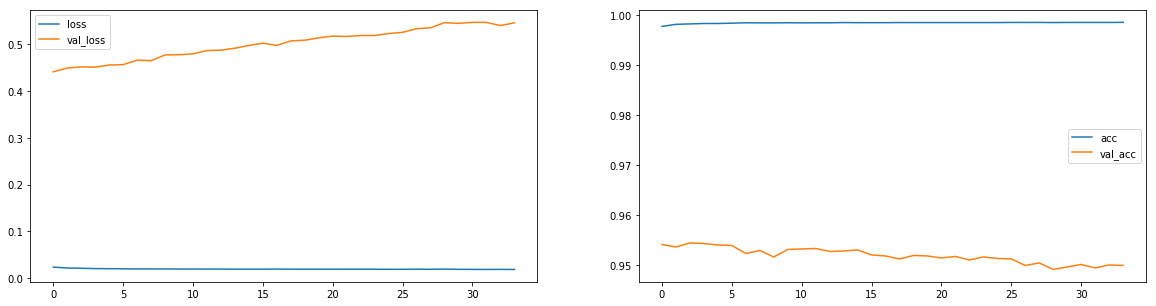


Epoch 00034: val_acc did not improve from 0.95440
Epoch 35/200
  128/48000 [..............................] - ETA: 1s - loss: 0.1264 - acc: 0.9922

KeyboardInterrupt: 

In [190]:
model_plane.fit(x_train, 
          y_train_categorical ,
          epochs=20, batch_size=batch_size, 
          #verbose=1, 
          validation_data=(x_test, y_test_categorical), 
          callbacks=[plot_losses, checkpointer],
         )

In [191]:
model_plane.evaluate(x_train, y_train_categorical)

48000/48000 [==============================] - 1s 26us/step


[0.01821215804256523, 0.9986041666666666]

In [192]:
model_plane.evaluate(x_test, y_test_categorical)

10000/10000 [==============================] - 0s 23us/step


[0.5466807018637424, 0.9499]

In [193]:
model_plane.load_weights('two-layer-2d.mnist.hdf5')
model_plane.evaluate(x_test, y_test_categorical)

10000/10000 [==============================] - 0s 24us/step


[0.4518938376360573, 0.9544]

## Me quedo con el modelo hasta la anteúltima capa

In [194]:
model_trunc = Model(model_plane.input, model_plane.layers[-2].output)
model_trunc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_26_input (InputLayer (None, 28, 28)            0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 784)               0         
_________________________________________________________________
middle1 (Dense)              (None, 200)               157000    
_________________________________________________________________
middle2 (Dense)              (None, 2)                 402       
Total params: 157,402
Trainable params: 157,402
Non-trainable params: 0
_________________________________________________________________


In [195]:
# Calculo de entorno
maxs = np.max(predictions, axis=0)
print(maxs)
N = 500
x1, x2 = np.meshgrid(np.linspace(0, maxs[0], N), np.linspace(0, maxs[1], N))
x_mesh = np.c_[x1.ravel(), x2.ravel()]
model_last_trunc = Sequential()
model_last_trunc.add(Dense(10, input_shape=(2,)))
model_last_trunc.set_weights(model_plane.get_layer('salida').get_weights())
pred_mesh = model_last_trunc.predict(x_mesh, verbose=1)
Z = np.argmax(pred_mesh, axis=1).reshape(x1.shape)/10

[5092.9478 8229.572 ]
250000/250000 [==============================] - 4s 15us/step


48000/48000 [==============================] - 1s 27us/step


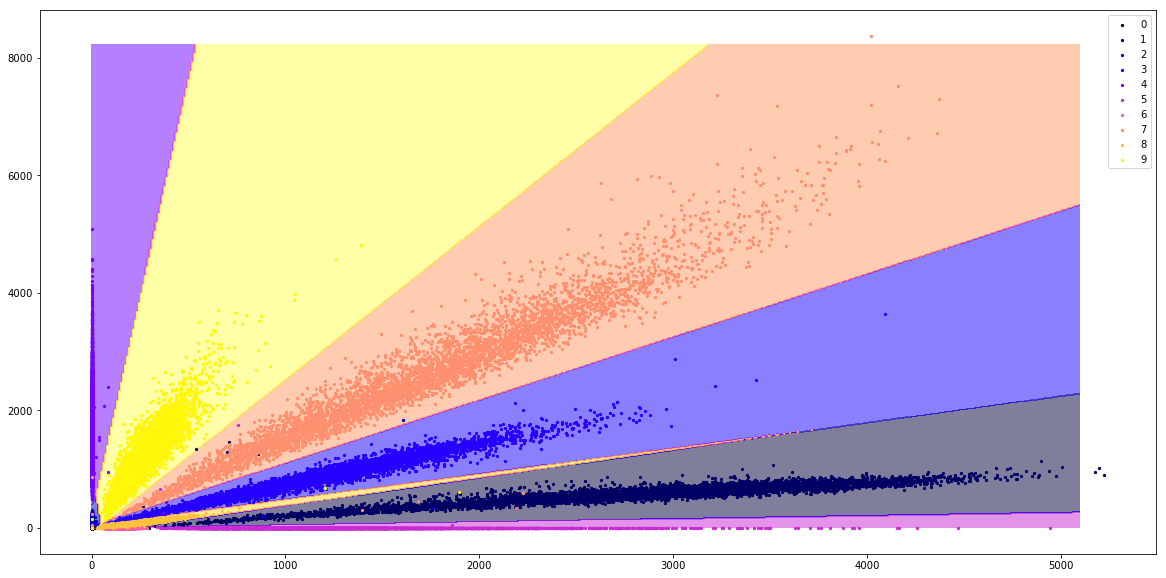

In [196]:
predictions = model_trunc.predict(x_train, verbose=1)
plt.figure(figsize=(20,10))
plt.contourf(x1, x2, Z, 10, cmap=plt.cm.gnuplot2, alpha=0.5)
#for i, c in enumerate(['red', 'green', 'blue', 'yellow', 'black', 'orange', 'brown', 'gray', 'purple', 'cyan']):
for i in range(10):
    plt.scatter(predictions[y_train == i, 0], predictions[y_train == i, 1], c=[plt.cm.gnuplot2(i/10)], s=5, label=str(i))
plt.legend()
plt.show()

12000/12000 [==============================] - 0s 17us/step


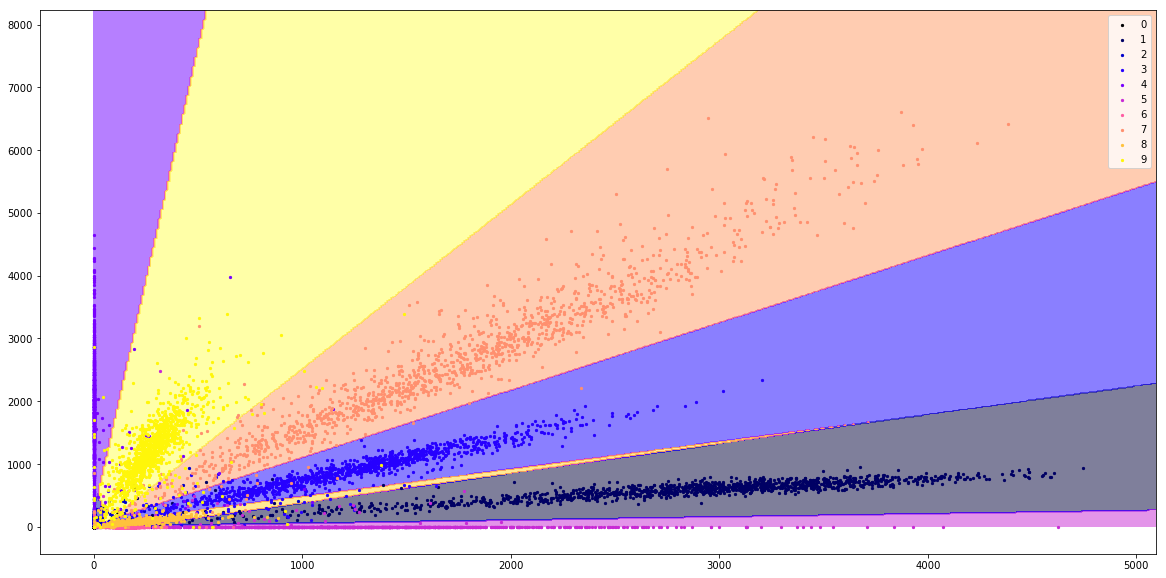

In [197]:
predictions_val = model_trunc.predict(x_val, verbose=1)
plt.figure(figsize=(20,10))
plt.contourf(x1, x2, Z, 10, cmap=plt.cm.gnuplot2, alpha=0.5)
#for i, c in enumerate(['red', 'green', 'blue', 'yellow', 'black', 'orange', 'brown', 'gray', 'purple', 'cyan']):
for i in range(10):
    plt.scatter(predictions_val[y_val == i, 0], predictions_val[y_val == i, 1], c=[plt.cm.gnuplot2(i/10)], s=5, label=str(i))
plt.legend()
plt.show()